# TensorFlow Hub 를 이용한 Transfer Learning

- Pre-trained Moblenet 사용  
- GPU 필요하므로 Colab에서 작업

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet import decode_predictions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

### Tensorflow Hub 에서 PRE-TRAINED MOBILENET 의 WEIGHT 를 가져옴  

TensorFlow Hub에서 제공하는 MobileNet_v2 사전 훈련 모델을 사용하여 입력 형태가 (224, 224, 3)인 단일 계층으로 구성된 Keras 모델을 생성합니다. 이 모델은 주로 이미지 분류 작업에 사용되는 MobileNet_v2 아키텍처를 기반으로 합니다.

In [2]:
Trained_MobileNet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

Trained_Mobilenet = tf.keras.Sequential([
                    hub.KerasLayer(Trained_MobileNet_url , input_shape=(224,224,3))]
                    )

Trained_Mobilenet.input: 이것은 모델의 입력 텐서입니다. 모델의 입력 형태는 (224, 224, 3)이며, 이는 RGB 이미지의 높이, 너비, 채널 수를 나타냅니다.  
Trained_Mobilenet.output: 이것은 모델의 출력 텐서입니다. 출력은 모델이 이미지를 분류하기 위해 사용하는 분류 점수를 나타냅니다. MobileNet_v2는 기본적으로 ImageNet 데이터 세트에 대해 훈련되어 있으므로, 출력 벡터의 길이는 1001이 됩니다. 각 요소는 해당 클래스의 확률 점수를 나타냅니다.

In [3]:
Trained_Mobilenet.input, Trained_Mobilenet.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_input')>,
 <KerasTensor: shape=(None, 1001) dtype=float32 (created by layer 'keras_layer')>)

###  Fine Tuning 전 특정 domain 의 Batch Image 에 대한 MobileNet 평가

MobileNet 은 Flower 에 특화된 model 이 아니므로 정확도 낮을 것으로 예상됩니다.  
get_file 함수를 사용하여 인터넷에서 꽃 이미지 데이터셋을 다운로드합니다.    다운로드할 파일의 이름을 'flower_photos'로 지정하고, 데이터셋의 URL을 인자로 전달합니다. untar=True는 파일이 tar 압축 형식이므로 다운로드 후 압축을 풀어야 함을 나타냅니다.

In [4]:
# flowers dataset
flowers_data_path = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 8s 0us/step


TensorFlow의 ImageDataGenerator를 사용하여 꽃 이미지 데이터셋에 대한 데이터 전처리를 수행합니다. ImageDataGenerator는 실시간 데이터 전처리 및 증강을 수행하며, 이미지 파일을 학습 데이터로 변환하는 데 사용됩니다. 이 예제에서는 MobileNet의 전처리 함수를 사용하여 이미지를 전처리합니다.  
ImageDataGenerator 객체인 image_generator를 생성한 후, flow_from_directory 함수를 사용하여 로컬 파일 시스템에서 이미지를 로드하고 전처리합니다. 이 함수는 이미지를 로드하고, 지정된 target_size(224 x 224)로 크기를 조정하며, 배치 크기를 64로 설정하여 데이터를 배치 단위로 반환합니다. shuffle=True는 데이터를 무작위로 섞어 과적합을 방지합니다.


In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

flowers_data = image_generator.flow_from_directory(flowers_data_path,
                    target_size=(224, 224), batch_size = 64, shuffle = True)

Found 3670 images belonging to 5 classes.


next() 함수를 사용하여 flowers_data에서 배치를 추출합니다.  
input_batch는 전처리된 이미지 데이터의 배치입니다. 이 경우, 배치 크기는 64이며, 각 이미지의 크기는 224 x 224 x 3이므로 배치의 모양(shape)은 (64, 224, 224, 3)입니다.  
label_batch는 이미지에 해당하는 원-핫 인코딩된 레이블 데이터의 배치입니다. 이 경우, 클래스 수가 5개이므로 레이블 배치의 모양은 (64, 5)입니다.  
flowers_data.num_classes는 데이터셋의 클래스 수를 반환합니다. 이 경우, 꽃 데이터셋에는 5개의 클래스가 있습니다.  
flowers_data.class_indices는 클래스 이름과 해당 인덱스를 포함하는 딕셔너리입니다. 이 정보는 이미지의 실제 레이블과 예측된 레이블을 비교할 때 유용합니다.

In [6]:
input_batch, label_batch = next(flowers_data)

print("Image batch shape: ", input_batch.shape)
print("Label batch shape: ", label_batch.shape)
print("Label class 수: ", flowers_data.num_classes)
print("Class Index : ", flowers_data.class_indices)

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)
Label class 수:  5
Class Index :  {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


 flowers_data.class_indices 딕셔너리의 키와 값의 위치를 바꾸어 새로운 딕셔너리 class_names를 생성합니다. 이렇게 하면, 인덱스를 사용하여 각 클래스의 이름을 쉽게 찾을 수 있습니다.

In [7]:
class_names = {v:k for k,v in flowers_data.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

첫 번째 배치에서 10개의 이미지를 시각화하여 그리드에 표시 합니다. 각 이미지의 전처리를 되돌려 정규화된 값을 원래 이미지의 값으로 변환합니다.

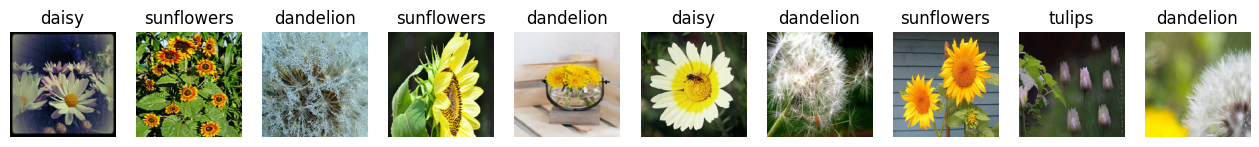

In [8]:
plt.figure(figsize=(16, 8))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    idx  = np.argmax(label_batch[i])
    plt.imshow(img)
    plt.title(class_names[idx])
    plt.axis('off')

임의의 꽃 image 1 개를 선택하여  예측을 수행합니다.


In [9]:
prediction = Trained_Mobilenet.predict(input_batch[2:3])
prediction.shape

1/1 [==============================] - 3s 3s/step


(1, 1001)

decode_predictions() 함수는 1000개의 클래스 레이블 중 확률이 가장 높은 상위 5개 결과를 인간이 이해할 수 있는 레이블로 변환해주는 함수입니다.  이 레이블은 [(class_id, class_name, class_probability)] 형태의 튜플 리스트로 반환합니다.


In [10]:
decode_predictions(prediction[:, 1:])

35363/35363 [==============================] - 0s 0us/step


[[('n11939491', 'daisy', 10.526314),
  ('n03930313', 'picket_fence', 7.522675),
  ('n04209239', 'shower_curtain', 6.121814),
  ('n02843684', 'birdhouse', 5.942684),
  ('n03457902', 'greenhouse', 5.81002)]]

### 전이학습 MODEL 을 Flower 분류에 적합한 model 로 Retrain

### Fine Tuning 을 위해 head 가 제거된 model 을 download  

- https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

In [11]:
extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

extractor_layer = hub.KerasLayer(extractor_url, input_shape=(224, 224, 3))

extractor_layer를 통해 입력 이미지 배치를 모바일넷으로 처리한 특성 벡터 배치를 얻습니다. 반환된 feature_batch의 shape를 출력해보면면, 64개의 이미지에 대해, 각 이미지는 1280 차원의 특성 벡터로 나타납니다.

In [12]:
feature_batch = extractor_layer(input_batch)
print(feature_batch.shape)

(64, 1280)


extractor_layer.trainable = False는 모델의 특정 레이어를 학습에서 제외시키는 역할을 합니다. 이를 통해 레이어의 가중치가 업데이트되지 않도록 하여 해당 레이어의 특성을 고정시켜 놓을 수 있습니다.

In [13]:
extractor_layer.trainable = False

### Model을 두 부분으로 구성:
-    (1)  MobileNet Feature Extractor
-   (2)  출력 부분에 Dense Network (classifier) 추가

In [14]:
model = tf.keras.Sequential([
  extractor_layer,
  tf.keras.layers.Dense(flowers_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [15]:
model.input, model.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_1_input')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>)

- output shape 이 정확한지 training 전에 사전 check해 봅니다.

In [16]:
predictions = model(input_batch)

In [17]:
predictions.shape

TensorShape([64, 5])

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(flowers_data, epochs=30)

Epoch 1/30
58/58 [==============================] - 15s 183ms/step - loss: 0.9673 - accuracy: 0.6417
Epoch 2/30
58/58 [==============================] - 11s 182ms/step - loss: 0.4751 - accuracy: 0.8401
Epoch 3/30
58/58 [==============================] - 10s 179ms/step - loss: 0.3900 - accuracy: 0.8711
Epoch 4/30
58/58 [==============================] - 10s 179ms/step - loss: 0.3352 - accuracy: 0.8891
Epoch 5/30
58/58 [==============================] - 10s 176ms/step - loss: 0.3017 - accuracy: 0.9016
Epoch 6/30
58/58 [==============================] - 10s 175ms/step - loss: 0.2739 - accuracy: 0.9114
Epoch 7/30
58/58 [==============================] - 10s 179ms/step - loss: 0.2546 - accuracy: 0.9199
Epoch 8/30
58/58 [==============================] - 10s 179ms/step - loss: 0.2385 - accuracy: 0.9243
Epoch 9/30
58/58 [==============================] - 10s 177ms/step - loss: 0.2182 - accuracy: 0.9354
Epoch 10/30
58/58 [==============================] - 11s 180ms/step - loss: 0.2053 - accura

### Flower 분류 전문으로 Fine Tuning 된 MODEL 평가

np.argmax() 함수를 이용하여 각 샘플의 예측값 중 가장 큰 값(즉, 가장 높은 확률값)에 해당하는 인덱스를 y_pred에 저장합니다.

In [20]:
y_pred = model.predict(input_batch)
y_pred = np.argmax(y_pred, axis=-1)
y_pred

2/2 [==============================] - 1s 13ms/step


array([4, 0, 3, 1, 3, 1, 0, 1, 3, 4, 1, 1, 4, 3, 1, 2, 3, 3, 2, 1, 3, 1,
       0, 4, 1, 3, 0, 3, 4, 1, 0, 1, 4, 4, 0, 1, 4, 3, 2, 2, 2, 2, 2, 4,
       4, 4, 1, 1, 1, 4, 1, 3, 4, 1, 1, 3, 2, 1, 3, 2, 4, 0, 2, 2])

In [21]:
y_true = np.argmax(label_batch, axis=-1)
y_true

array([4, 0, 3, 1, 3, 1, 0, 1, 3, 4, 1, 1, 4, 3, 1, 2, 3, 3, 2, 1, 3, 1,
       0, 4, 1, 3, 0, 3, 4, 1, 0, 1, 4, 4, 0, 1, 4, 3, 2, 2, 2, 2, 2, 4,
       4, 2, 1, 1, 1, 4, 1, 3, 4, 1, 1, 3, 2, 1, 3, 2, 4, 0, 2, 2])

 y_pred와 y_true 간의 일치하는 값의 비율을 계산하여 백분율로 나타냅니다

In [22]:
f"{sum(y_pred == y_true) / len(y_true) * 100:.2f} %"

'98.44 %'

이전과 마찬가지로  각 이미지의 전처리를 되돌려 정규화된 값을 원래 이미지의 값으로 변환합니다.

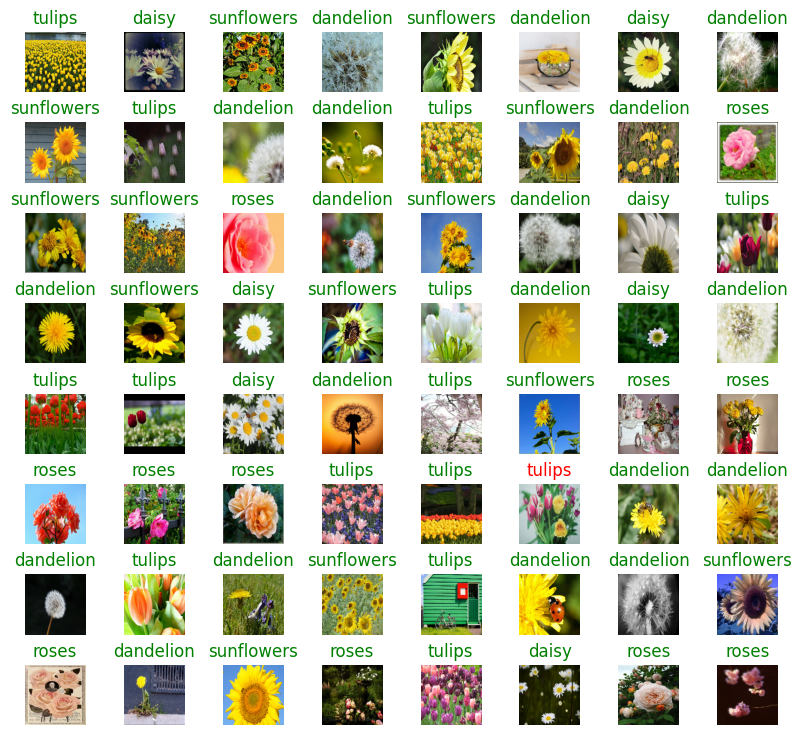

In [23]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for i in range(64):
    plt.subplot(8, 8, i+1)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    plt.imshow(img)
    color = "green" if y_pred[i] == y_true[i] else "red"
    plt.title(class_names[y_pred[i]], color=color)
    plt.axis('off')
